# Продажи компьютерных игр в интернет магазине

Источник данных - данные по продажам компьютерных игр до 2017 года

Необходимо используя исторические данные о продажах компьютерных игр, оценки пользователей и экспертов, жанры и платформы, выявить закономерности, определяющие успешность игры 

## Импорты

### Импорт библиотек

In [936]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import plotly.express as px
import plotly.graph_objects as go

from dataclasses import dataclass

from scipy import stats as st

from io import BytesIO
import requests

%matplotlib inline

Импорт данных

In [937]:
try:
    data_games = pd.read_csv('../datasets/games.csv')
except:
    pass

## Очистка и предобработка данных

### Краткий анализ данных

In [938]:
display(data_games.head())

display(data_games.info())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

Датафрейм имеет пропущенные данные. Также можно предположить, что `Name` не должно повторяться

### Преобразование колонок в нижний регистр

In [939]:
data_games.columns = [x.lower() for x in data_games.columns]

In [940]:
category_col = ['name','platform','genre']
for col in category_col:
    data_games[col] = data_games[col].str.lower()

In [941]:
print(f"Количество дубликатов: {data_games.duplicated().sum()}")

Количество дубликатов: 0


### Проверка на дубликаты среди игр

In [942]:
data_games.name.value_counts()[:10]

need for speed: most wanted    12
madden nfl 07                   9
fifa 14                         9
ratatouille                     9
lego marvel super heroes        9
monopoly                        8
fifa soccer 13                  8
terraria                        8
madden nfl 08                   8
cars                            8
Name: name, dtype: int64

Мы видим, что среди игр есть повторяющиеся названия. Изучим этот момент более подробно

In [943]:
data_games.query('name == "need for speed: most wanted"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,need for speed: most wanted,ps2,2005.0,racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,need for speed: most wanted,ps3,2012.0,racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,need for speed: most wanted,x360,2012.0,racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,need for speed: most wanted,x360,2005.0,racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,need for speed: most wanted,xb,2005.0,racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,need for speed: most wanted,psv,2012.0,racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,need for speed: most wanted,gc,2005.0,racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,need for speed: most wanted,pc,2005.0,racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,need for speed: most wanted,wiiu,2013.0,racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,need for speed: most wanted,ds,2005.0,racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Мы видим, что в целом различаются платформы выхода и внутри одной платформы. Проверим совпадают ли имя игры платформа и год релиза

In [944]:
data_games[['name','platform','year_of_release']].duplicated().sum()

2

Видим два дубликата, уточняем, что это за данные

In [945]:
data_games[data_games[['name','platform','year_of_release']].duplicated(keep=  False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,ps3,2012.0,sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,gen,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,gen,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,madden nfl 13,ps3,2012.0,sports,0.00,0.01,0.00,0.00,83.0,5.5,E


Новые строчки это скорее допродажи или корректировки. Избавимся от данных дубликатов, хотя они не должны были принципиально повлиять на наш анализ

In [946]:
data_games.loc[604,'eu_sales'] = data_games.loc[604,'eu_sales'] + data_games.loc[16230,'eu_sales'] 
data_games.loc[1745,'eu_sales'] = data_games.loc[1745,'eu_sales'] + data_games.loc[4127,'eu_sales'] 

In [947]:
data_games = data_games.drop_duplicates(subset = ['name','platform','year_of_release'])

### Преобразование user_score

tbd - это скорее всего 'to be discussed', а именно подлежит уточнению. Создадим пока временный столбец для того, чтобы понять зависимости, заменим пока на пропуск и преобразуем `user_score` к типу float

In [948]:
data_games['user_score_temp'] = data_games.user_score.replace('tbd', np.nan)
data_games.user_score_temp = data_games.user_score_temp.astype(float)

### Матрица корреляций между числовыми переменными

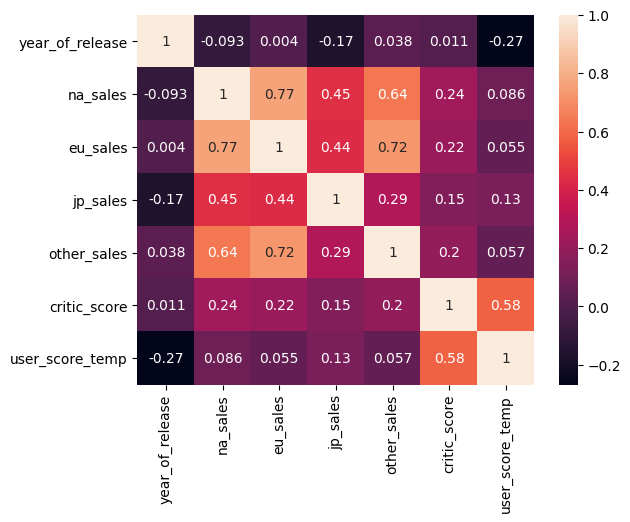

In [949]:
sns.heatmap(data_games.corr(),annot = True);

согласно матрице корреляции мы видим
- Высокая корреляция между `eu_sales` и `na_sales`, что ожидаемо. Продажи игр на рынке Северной Америки коррелирует с продажами на рынке Европы
- Имеется высокая корреляция между `other_sales` и `eu_sales`
- При этом наблюдается средняя корреляция между `other_sales` и `na_sales`, что говорит о том, что эти рынки похожи, но меньше
- Имеется средняя корреляция между `critic_score` и `user_score`
- `jp_sales` слабо коррелирует с `eu_sales` и `na_sales`

### Замена пропусков

In [950]:
(pd.concat([data_games.isna().sum(), data_games.isna().sum() / data_games.shape[0]],axis = 1)
   .rename(columns = {0:'count_missing',1:'per_missing'})
   .sort_values('per_missing', ascending = False)
   .style.format({'per_missing': '{:.1%}'}))

,count_missing,per_missing
user_score_temp,9124,54.6%
critic_score,8577,51.3%
rating,6765,40.5%
user_score,6700,40.1%
year_of_release,269,1.6%
name,1,0.0%
genre,1,0.0%
platform,0,0.0%
na_sales,0,0.0%
eu_sales,0,0.0%


В данных имеются пропуски, проверим процент пропусков в данных и заменим их правильно (сохраняя максимум данных для анализа)

####  name и genre

In [951]:
data_games[data_games.name.isna() | data_games.genre.isna() ]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,user_score_temp
659,NaN,gen,1993.0,NaN,1.78,0.53,0.0,0.08,NaN,NaN,NaN,NaN


Мы видим, что данная строчка почти не несет полезной информации, жанр и имя игры не указаны. Удалим данные строки, так как пропусков менее 0.012% и года релиза игр достаточно старые

In [952]:
data_games.dropna(subset = ['name'],inplace = True)

#### Функция для более качественной обработки данных

❗ ранее мы видели, что имеются разные игры, выпущенные на разных платформах у которых, в некоторых платформах были пропуски \
Напишем функцию, которая ищет по заданному столбцу пропуски, ищет совпадения без пропусков и заменяет  на медианное значения для числа и на первое значение для категории

In [953]:
def replace_nan_data(data:pd.DataFrame,column:str):
    """На вход принимает датафрейм и колонку, на выходе
    получается обработанный датафрейм"""
    method = 'median'
    if pd.api.types.is_numeric_dtype(data[column]) == False:
        method = 'first'
    
    data[column] = data[column].fillna(
            data.groupby('name')[column].transform(method))
    return data

#### year_of_release

Заполним данные известными годами

Функцию replace_nan_data нельзя применять к существующим играм, так как они могут выпускаться в разное время на разных платформах и переиздаваться. Это может привести к некорректному заполнению пропусков

In [954]:
data_games[data_games['year_of_release'].isna()].nunique()

name               232
platform            16
year_of_release      0
genre               12
na_sales            69
eu_sales            47
jp_sales            26
other_sales         27
critic_score        56
user_score          48
rating               5
user_score_temp     47
dtype: int64

In [955]:
data_games[data_games['year_of_release'].isna()].platform.unique()

array(['ps2', 'wii', '2600', 'x360', 'gba', 'pc', 'ps3', 'ps', 'psp',
       'xb', 'gb', 'ds', 'gc', '3ds', 'n64', 'psv'], dtype=object)

Предположим что год выхода игры зависит от платформы, на которой эта игра была выпущена

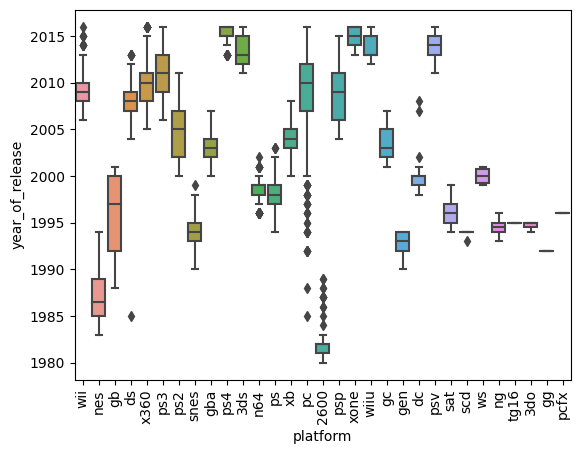

In [956]:
sns.boxplot(data=data_games, x="platform", y="year_of_release")

plt.xticks(rotation=90)
plt.show()

По боксплоту видно, что в целом предположение подтвердилось и по платформе можно предсказать примерную дату выхода игры. В целом наше предположение подтвердилось, поэтому дату релиза заполняем медианным значением по платформе

In [957]:
data_games.year_of_release = data_games.year_of_release.fillna(
            data_games.groupby('platform')['year_of_release'].transform('median'))

И преобразуем данное значение в int для дальнейшего удобства

In [958]:
data_games.year_of_release = data_games.year_of_release.astype(int)

#### rating

Проведем анализ пропусков в рейтинге

Мы знаем, что рейтинг был основан в 1994 году(из открытых источников. Проверим предположение, что до этого времени рейтинг не присваивался

In [959]:
data_games.query('year_of_release < 1994').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382 entries, 1 to 16207
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             382 non-null    object 
 1   platform         382 non-null    object 
 2   year_of_release  382 non-null    int32  
 3   genre            382 non-null    object 
 4   na_sales         382 non-null    float64
 5   eu_sales         382 non-null    float64
 6   jp_sales         382 non-null    float64
 7   other_sales      382 non-null    float64
 8   critic_score     3 non-null      float64
 9   user_score       3 non-null      object 
 10  rating           4 non-null      object 
 11  user_score_temp  3 non-null      float64
dtypes: float64(6), int32(1), object(5)
memory usage: 37.3+ KB


В целом почти все игры не получили рейтинг за исключением трех игр. Далее в задании нам необходимо будет определить актуальный период. Но в данном случае период до 1994 года уже можно будет в будущем исключить\
Далее мы знаем из открытых источников, что рейтинг создавался торговой ассоциацией в США. Проверим, возможно, если игра вышла на локальном рынке то ей просто не присваивали рейтинг

In [960]:
data_games[data_games['rating'].isna()]['na_sales'].describe(percentiles=[0,0.2,0.4,0.5,0.6,0.8,0.9,1])

count    6764.000000
mean        0.183424
std         0.796083
min         0.000000
0%          0.000000
20%         0.000000
40%         0.000000
50%         0.000000
60%         0.030000
80%         0.170000
90%         0.420000
100%       29.080000
max        29.080000
Name: na_sales, dtype: float64

Из пропусков где-то около 10 процентов имели значимые продаж, остальным же играм скорее всего рейтинг не присваивался. Тем не менее это классификация игр по возрастам и присвоить статус локальная в рейтинге мы не можем. 

Заполним рейтинг известными значениями

In [961]:
data_games = replace_nan_data(data_games,'rating')

Затем заполним оставшиеся значения модой по жанрам

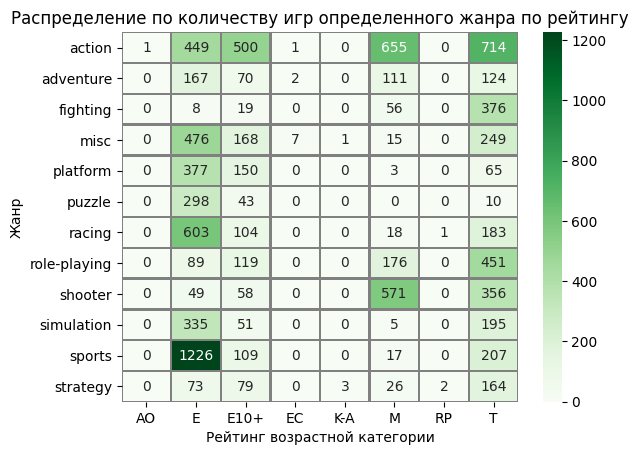

In [962]:
ax =sns.heatmap(pd.crosstab(data_games.genre, data_games.rating),annot = True,fmt='.5g',
            cmap= 'Greens', linewidths=1, linecolor='grey');

ax.set_xlabel('Рейтинг возрастной категории')
ax.set_ylabel('Жанр')
ax.set_title('Распределение по количеству игр определенного жанра по рейтингу');

В целом мы видим, что в каждом рейтинге доминирует свой жанр, и можно предположить, что игры с жанром спорт будут иметь ограничение в E и так далее

In [963]:
# for genre in data_games.genre.unique():
#     data_games.loc[(data_games['genre'] == genre) & (data_games['rating'].isna()), 'rating']  = \
#     data_games.dropna(subset = ['rating']).query('genre == @genre')['rating'].mode()[0]

Тем не менее в разных герионах рейтинги могут отличаться. Поэтому заполним рейтинг неизвестным значением

In [964]:
data_games['rating'] = data_games['rating'].fillna('unknown')

#### user_score

tbd - это скорее всего 'to be discussed', а именно подлежит уточнению. Ранее мы создавали `user_score_temp`. По итогу удаляем временный столбец и проделываем все те же действия

In [965]:
data_games['user_score'] = (data_games['user_score']
                            .replace('tbd', np.nan)
                            .astype(float))

In [966]:
data_games = data_games.drop(columns = 'user_score_temp')

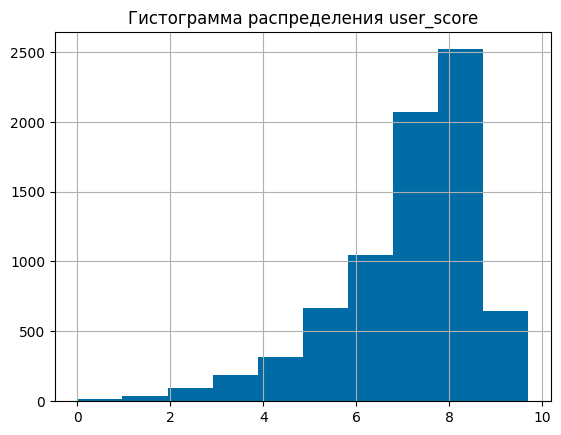

In [967]:
data_games['user_score'].hist()
plt.title('Гистограмма распределения user_score')
plt.show()

Проверим, как распределены медианы рейтингов по категориальным данным. Для этого введем функцию, которая строит два графика по заданному столбцу

In [968]:
def get_category_graph(col_rate:str):
    fig, axs = plt.subplots(1,2, figsize = (9,5))
    axs = axs.flatten()

    sns.boxplot(data = data_games, x = 'platform' , y = col_rate,
               ax = axs[0])
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].set_ylabel("")
    axs[0].set_title(f"Распределение показателя {col_rate} по платформам",fontsize=10)

    sns.boxplot(data = data_games, x = 'genre' , y = col_rate,
               ax = axs[1])
    axs[1].tick_params(axis='x', rotation=90)
    axs[1].set_ylabel("")
    axs[1].set_title(f"Распределение показателя {col_rate} по жанрам", fontsize=10)
    plt.tight_layout()
    plt.show()

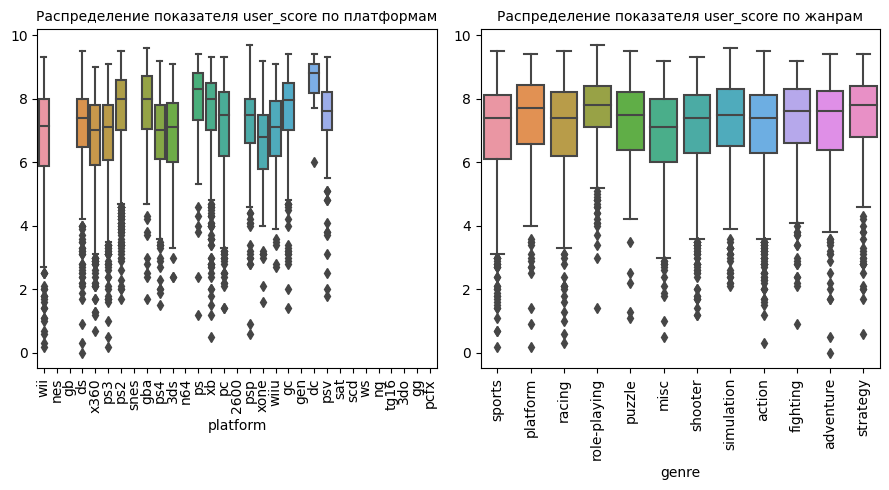

In [969]:
get_category_graph('user_score')

Мы видим, что по тем платформам, у которых оценка пользователя заполнена, они сильно отличаются (далее в задании были проведены стат тесты). Следовательно можно было бы заполнить их медианой.
Но у нас аналитический проект, поэтому на текущий момент оставим эти пропуски пустыми

#### critic_score

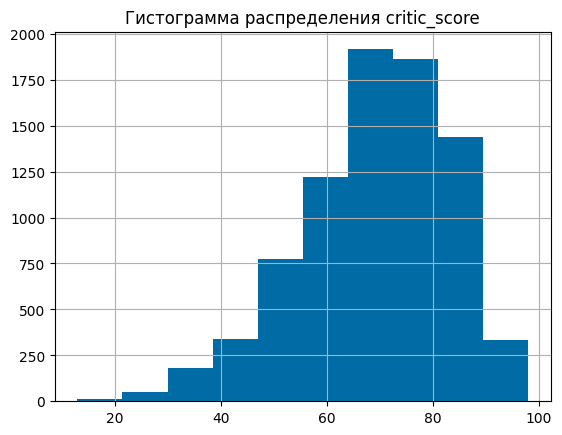

In [972]:
data_games['critic_score'].hist()
plt.title('Гистограмма распределения critic_score')
plt.show()

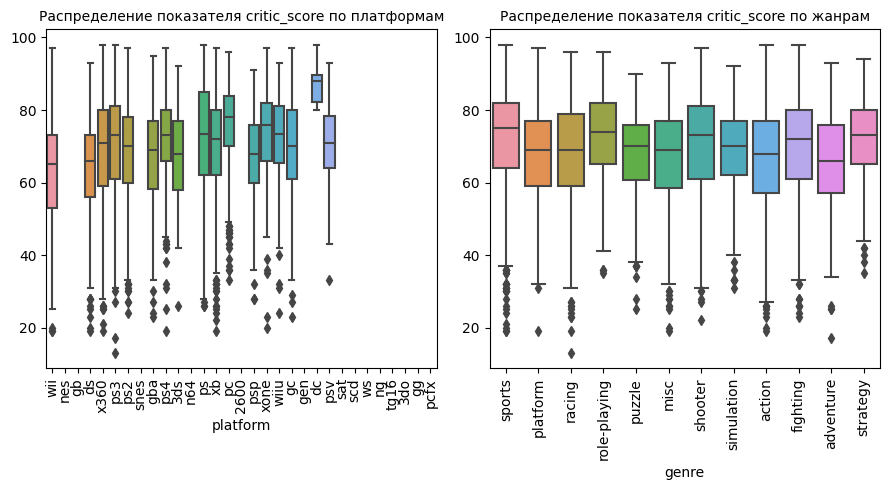

In [973]:
get_category_graph('critic_score')

Мы видим , что оценки критиков сильно отличаются в зависимости от пратформы. Поступаем аналогично user_score

### Суммарные продажи во всех регионах

Создадим данный столбец для дальнейшего анализа

In [977]:
data_games['total_sales'] =  data_games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis = 1)

<div style="text-align: letf; background-color: #D0ECEE;font-size:100%; font-family:Tahoma; color: #000000">

      Итого 
- `name` и `genre` удалили
- `year_of_release`  заполнили медианой по платформе
- `rating` - заполнили известными значаниями, если есть название игры и модой по жанру
- `critic_score` и `user_score` заполнили медианами по платформам

In [979]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16712 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16712 non-null  object 
 2   year_of_release  16712 non-null  int32  
 3   genre            16712 non-null  object 
 4   na_sales         16712 non-null  float64
 5   eu_sales         16712 non-null  float64
 6   jp_sales         16712 non-null  float64
 7   other_sales      16712 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       7589 non-null   float64
 10  rating           16712 non-null  object 
 11  total_sales      16712 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 2.1+ MB


## Исследовательский анализ данных

### Количество игр по годам

Построим распределение

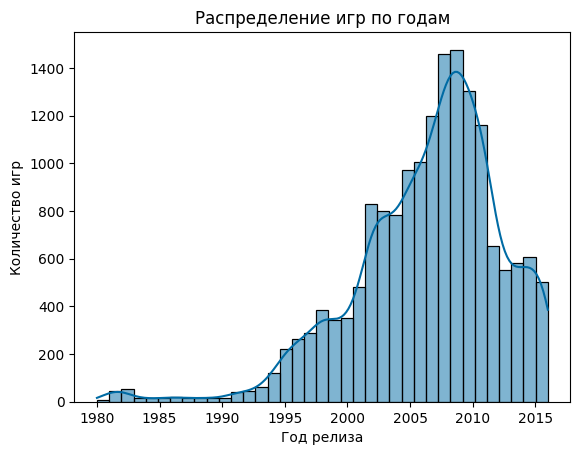

In [980]:
sns.histplot(data = data_games, x = 'year_of_release',
        bins = data_games.year_of_release.nunique(),kde = True)

plt.title("Распределение игр по годам")
plt.xlabel("Год релиза")
plt.ylabel('Количество игр')
plt.show()

Исходя из текущих данных мы видим, что основное тренд роста начался с 1990 года, то есть остальные года до этого периода можно исключить и не учитывать в дальнейшем распределении

### Анализ изменения продаж по платформам

In [981]:
platform_list = list(data_games.groupby('platform')['total_sales'].sum().sort_values(ascending = False)[:12].index)

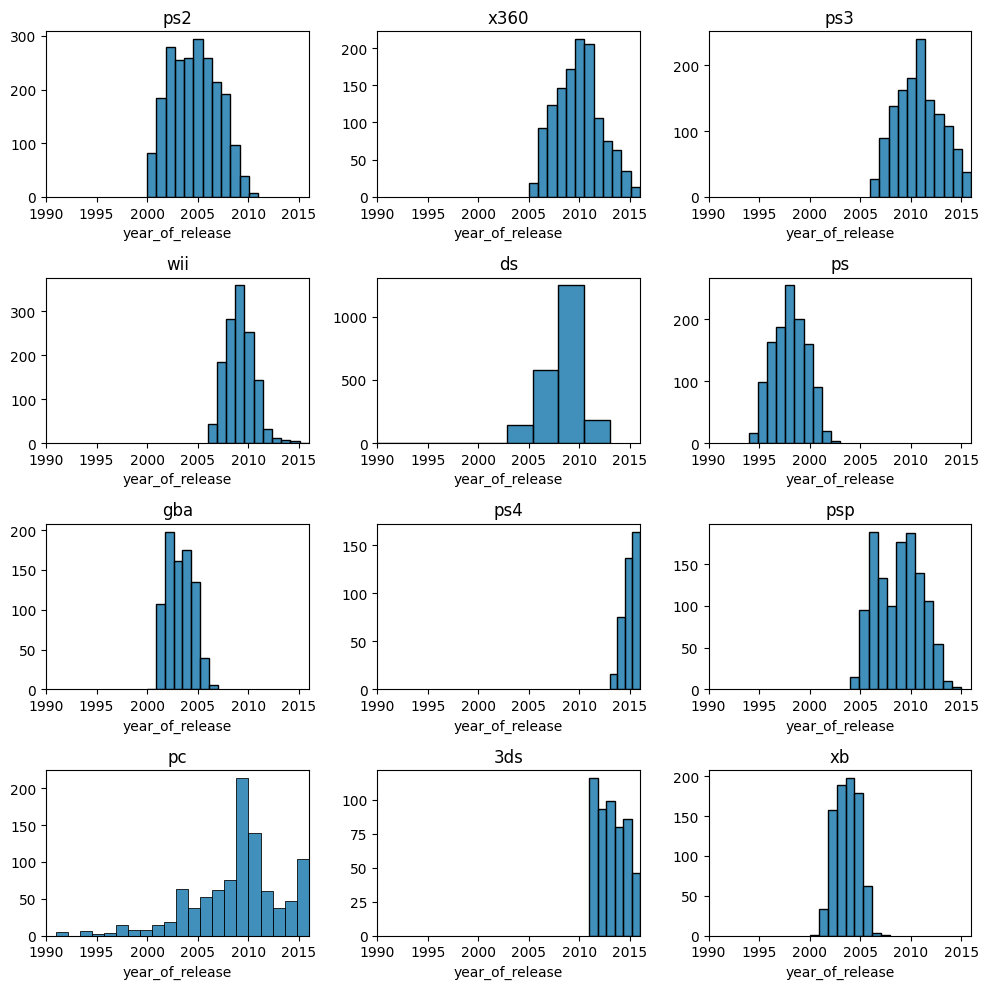

In [982]:
fig, axs = plt.subplots(4,3,figsize = (10,10))

axs = axs.flatten()

for num, platform in enumerate(platform_list):
    sns.histplot(data = data_games.query('platform == @platform'), x = 'year_of_release' ,
                  bins = data_games.query('platform == @platform').year_of_release.nunique(), 
                  ax = axs[num])
    
    axs[num].set_xlim(1990, 2016)
    axs[num].set_ylabel('')
    axs[num].set_title(platform)
    axs[num].set_xticks([x for x in range(1990,2020,5)])
    
    
plt.tight_layout()

В целом можно заметить, что срок за 7-10 лет появляются новые платформы, которые сменяют старые

In [983]:
data_games_platform_year  = data_games.groupby('platform')['year_of_release'].agg(['min','max'])
data_games_platform_year.columns = ['start','finish']
data_games_platform_year.reset_index(inplace=True)
data_games_platform_year['life_year'] = data_games_platform_year['finish'] - data_games_platform_year['start'] 

In [984]:
data_games_platform_year.life_year.value_counts()

11    4
0     3
3     3
5     3
9     3
10    3
1     2
4     2
6     2
2     1
7     1
8     1
13    1
28    1
31    1
Name: life_year, dtype: int64

In [985]:
data_games_platform_year = data_games_platform_year[~data_games_platform_year.platform.isin(['pc','ds'])]
data_games_platform_year = data_games_platform_year[data_games_platform_year['life_year'] > 2]
data_games_platform_year = data_games_platform_year[~data_games_platform_year.platform.isin(['xone','ps4'])]

In [986]:
data_games_platform_year.life_year.mean()

7.9523809523809526

Итого мы видим, что средний возраст жизни платформы 8 лет.

In [987]:
year_of_release_list = list(data_games.year_of_release.unique())
platform_list = list(data_games.platform.unique())

data_animated = pd.DataFrame(index= pd.MultiIndex.from_product([year_of_release_list,platform_list],
                                               names = ['year_of_release','platform'])).reset_index()
data_games_group = data_games.groupby(['year_of_release','platform'],as_index= False)['total_sales'].sum()

data_animated = data_animated.merge(right=data_games_group, how = 'left' , on = ['year_of_release','platform'])
data_animated.fillna(0,inplace = True)
data_animated = data_animated.sort_values('year_of_release')
data_animated.loc[:,'total_sales_cum'] = data_animated.groupby('platform')['total_sales'].cumsum()

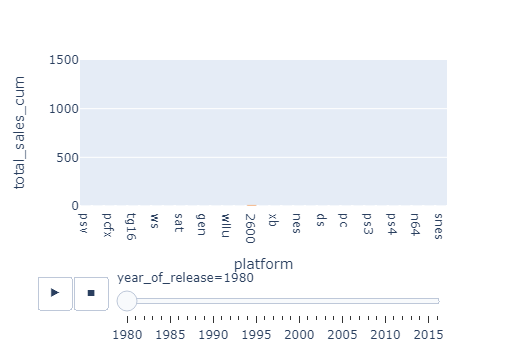

In [988]:
fig = px.bar(data_animated, x="platform", y="total_sales_cum", color="platform",
  animation_frame="year_of_release", animation_group="platform",range_y=[0,1500])

fig.update(layout_showlegend=False)
fig.show()

Исходя из данного графика мы видим, что период жизни PS связан с выходом новой версии, так же, как и XBox

### Определение потенциально прибыльных платформ

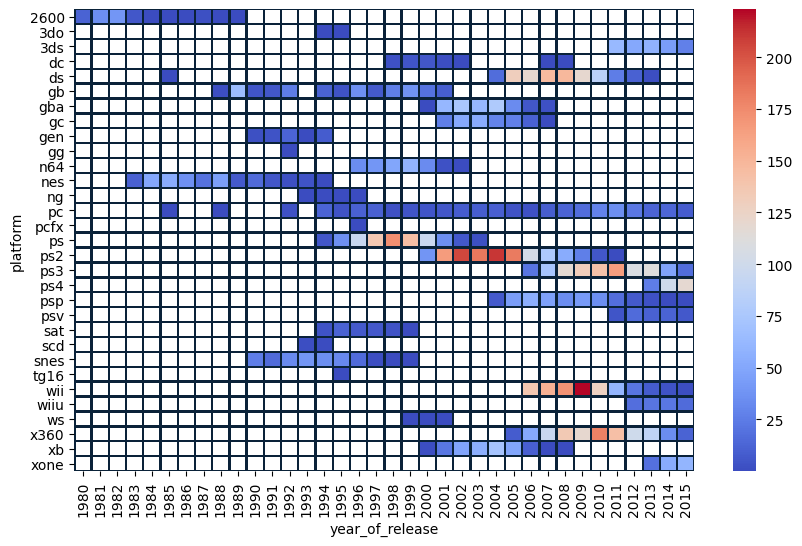

In [989]:
plt.figure(figsize = (10,6))

sns.heatmap(data_games.query('year_of_release < 2016').pivot_table(index = 'platform', columns = 'year_of_release', 
                       values = 'total_sales' , aggfunc='sum'), cmap = 'coolwarm',
           linewidths = 1, linecolor='#0A2239',xticklabels=True, yticklabels=True)
plt.show()

'PS3' и 'XOne' - имеют положительную динамику \
'3DS' и 'PC' также можно выделить

In [990]:
data_games.query('year_of_release > 2013').groupby('platform')['total_sales'].sum().sort_values(ascending = False)

platform
ps4     288.15
xone    140.36
3ds      86.68
ps3      68.18
x360     48.22
wiiu     42.98
pc       27.05
psv      22.66
wii       5.07
psp       0.36
Name: total_sales, dtype: float64

WiiU  -также можно отнести к прибыльным платформам

Итого прибыльные платформы - 'ps4', 'xone', '3ds', 'pc' ,'wiiu', ps3 - период активных продаж закончился и они идут на спад

In [991]:
data_games = data_games.query('year_of_release > 2013')

### Глобальные продажи по платформам

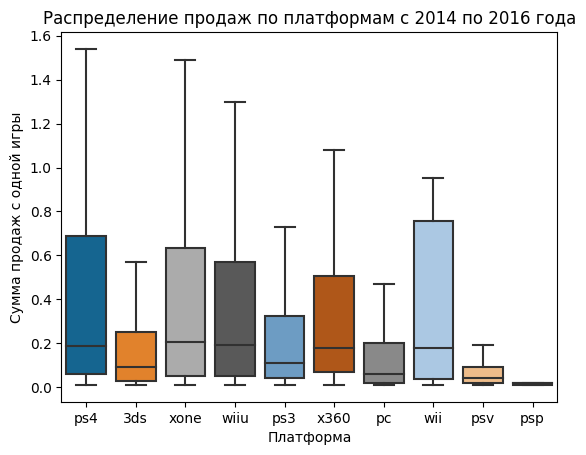

In [992]:
g = sns.boxplot(data=data_games, x="platform", y="total_sales",showfliers=False)
g.set_title("Распределение продаж по платформам c 2014 по 2016 года")
g.set_xlabel('Платформа')
g.set_ylabel('Сумма продаж с одной игры');

Построим график с усами, предварительно его прологарифмируя, инача данные сливаются и становятся неразличимыми

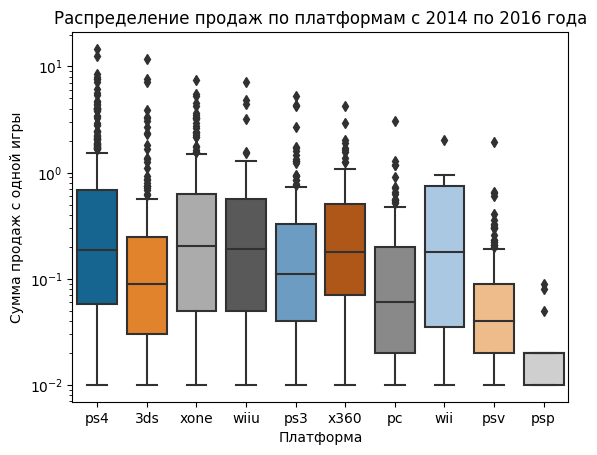

In [993]:
g = sns.boxplot(data=data_games, x="platform", y="total_sales")
g.set_yscale("log")
g.set_title("Распределение продаж по платформам c 2014 по 2016 года")
g.set_xlabel('Платформа')
g.set_ylabel('Сумма продаж с одной игры');

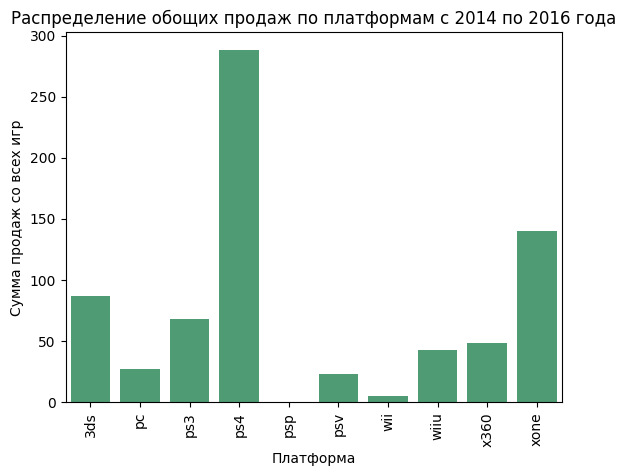

In [994]:
g = sns.barplot(data=data_games.groupby("platform",as_index= False)["total_sales"].sum(),
                x = 'platform', y = 'total_sales', color='#42A974')
g.set_xlabel('Платформа')
g.set_ylabel('Сумма продаж со всех игр')
g.set_title("Распределение обoщих продаж по платформам c 2014 по 2016 года")
g.set_xticklabels(g.get_xticklabels(),rotation=90);

Тем не менее мы видим, что не смотря на примерно схожие медианные значения, выручка отличается значительно. То для платформ в первую очередь важны хиты и топ игры, которые "выбиваются" из общей выборки и при развитии своей платформы надо делать упор именно на них

### Отзывы и критики

In [995]:
def return_plot_platform_corr(platform):
    plt.figure(figsize=(6,3))
    plt.subplot(121)
    ax = sns.regplot(data = data_games.query(f'platform == "{platform}"'), x = 'critic_score' , y = 'total_sales'
                     , order=4, ci=None,line_kws={"color": "C1"})
    ax.set_xlabel('Оценка критиков')
    ax.set_ylabel('Продажи')
    plt.subplot(122)

    ax1 = sns.regplot(data = data_games.query(f'platform == "{platform}"'), x = 'user_score' , y = 'total_sales'
                      , order=5, ci=None,line_kws={"color": "C1"})
    ax1.set_xlabel('Оценка зрителей')
    ax1.set_ylabel('')
    plt.show()

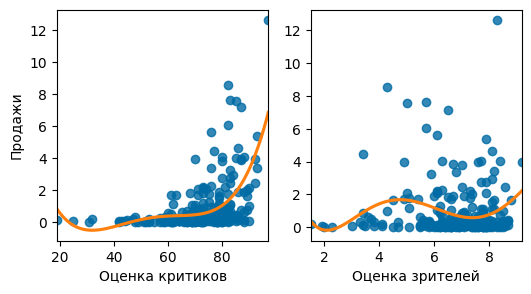

In [996]:
return_plot_platform_corr('ps4')

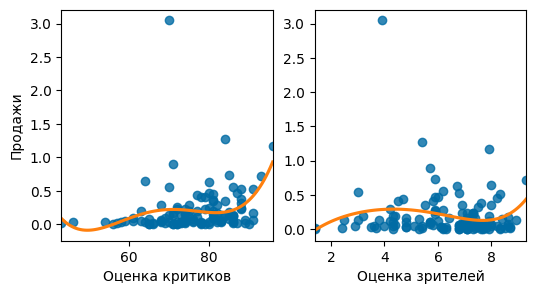

In [997]:
return_plot_platform_corr('pc')

Мы видим, по популярным платформам в целом наблюдается зависимость между оценкой зрителей и критиков. Хотя среди зрителей больше оценок меньше 50 баллов у игр с высокими продажами. Критики же играм с высокими продажами почти не ставят оценки ниже 60

In [998]:
data_games[['critic_score','user_score','total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.504634,0.327835
user_score,0.504634,1.000000,-0.013273
total_sales,0.327835,-0.013273,1.000000


Исходя из корреляции зависимостей не наблюдается

### Продажи на других платформах

In [999]:
data_games.groupby('platform',as_index = False)['total_sales'].sum().sort_values('total_sales', ascending = False)[:20]

,platform,total_sales
3,ps4,288.15
9,xone,140.36
0,3ds,86.68
2,ps3,68.18
8,x360,48.22
7,wiiu,42.98
1,pc,27.05
5,psv,22.66
6,wii,5.07
4,psp,0.36


- Итого в целом можно заметить, что у игр не было хитов, и из-за этого у них было меньше продаж
- Также стоит отметить популярность платформ. В среднем она живет около 5 лет

### Распределение по жанрам

In [1000]:
df_local = pd.concat([data_games.groupby('genre')['total_sales'].sum().sort_values(ascending = False) / data_games['total_sales'].sum(),
          data_games.groupby('genre')['total_sales'].sum().sort_values(ascending = False)] ,axis = 1).reset_index()

df_local.columns = ['genre' ,'per_sales', 'total_sales']
df_local['per_sales_c'] = df_local['per_sales'].cumsum()
df_local.style.format({'per_sales_c': '{:.2%}','per_sales': '{:.2%}','total_sales': '{:.2f}'})

,genre,per_sales,total_sales,per_sales_c
0,action,27.32%,199.36,27.32%
1,shooter,23.43%,170.94,50.75%
2,sports,15.00%,109.48,65.75%
3,role-playing,13.94%,101.70,79.69%
4,misc,5.15%,37.55,84.83%
5,fighting,3.87%,28.22,88.70%
6,racing,3.77%,27.52,92.47%
7,platform,2.48%,18.09,94.95%
8,adventure,2.41%,17.55,97.36%
9,simulation,1.80%,13.13,99.15%


- Action и Sports - явные лидеры
- Strategy, Puzzle, Adventure - аутсайдеры

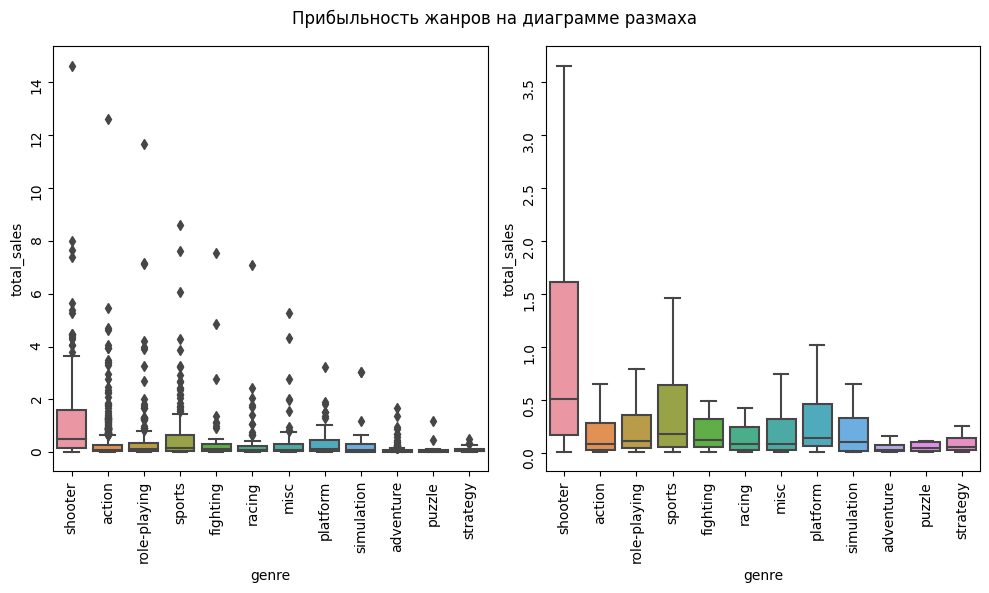

In [1001]:
fig, axs = plt.subplots(1,2,sharex =True, figsize = (10,6))
fig.suptitle("Прибыльность жанров на диаграмме размаха")

ax1, ax2 = axs.flatten()
sns.boxplot(data = data_games, x = 'genre' , y = 'total_sales', 
            ax = ax1)

sns.boxplot(data = data_games, x = 'genre' , y = 'total_sales', 
            ax = ax2, showfliers=False)
for ax in axs.flatten():
    ax.tick_params(labelrotation=90)

plt.tight_layout()

<div style="text-align: letf; background-color: #D0ECEE;font-size:100%; font-family:Tahoma; color: #000000">

      Итого 
- Средний период жизни платформы 7 лет
- Наиболее прибыльные в будущем платформы, те которые не устарели, и у которых в последние годы есть продажи.  Это PS4, XOne,3DS,Wii,PS3,PC
- Среди платформ, имеюших тенденцию к росту можно отметить PS4 И XOne. Также можно отметить PC платформу, которая имеет стабильные продажи с 1995 года
- Оценка зрителей коррелирует с продажами игр, оценка критиков нет. При этом зависимость есть. на популярных площадках критики чаще угадывают топ игры и редко им стявят низкие оценки
- Для платформ в первую очередь важно следить за сроком жизни. Это особенно заметно на PS, где стараются регулярно обновлять её
- Для платформ важно наличие хитов, именно они определяют, будет ли платформа иметь прибыль. Медианное значение млн продаж игр примерно у всех игр схоже
- Среди жанров наблюдается четкое разделение по популярность. Наиболее популярные жанры это Action и Sports. Менее популярные Adventure, Strategy, Puzzle
- Shooter - наиболее стабильная платформа. Action и Sports находятся в топе по продажам за счёт хитов

## Портрет пользователя

Построим класс, который составляет портрет пользователя. Для этого воспользуемся методами ООП, чтобы сделать удобное API

In [1002]:
@dataclass(frozen=True)
class Region():
    North_America = 'na_sales'
    Europe = 'eu_sales'
    Japan = 'jp_sales'
    Other = 'other_sales'
    

class InfoRegion():
    
    def __init__(self, data:pd.DataFrame):
        self.data = data

    def get_all_top_platform(self,name_sales_region:Region):
        data_local = (self.data.groupby('platform',as_index=  False)[name_sales_region]
                           .sum().sort_values(by = name_sales_region,ascending = False)
                           .reset_index(drop=True))
        data_local.loc['other'] = ['other',data_local.iloc[5:][name_sales_region].sum()]
        data_local = data_local.iloc[[0,1,2,3,4,-1]].reset_index(drop = True)
        return  data_local
    
    def get_all_top_genre(self,name_sales_region:Region):
        data_local = (self.data.groupby('genre',as_index=  False)[name_sales_region]
                           .sum().sort_values(by = name_sales_region,ascending = False))
        
        data_local.loc['other'] = ['other',data_local.iloc[5:][name_sales_region].sum()]
        data_local = data_local.iloc[[0,1,2,3,4,-1]].reset_index(drop = True)
        return data_local
    
    def platform_barplot(self,name_sales_region:Region, ax = None):
        data = self.get_all_top_platform(name_sales_region)
        ax = sns.barplot(data = data, x = 'platform', y = name_sales_region, ax=ax)
        ax.set_ylabel('Продажи')
        ax.set_xlabel('')
        ax.tick_params(labelrotation=90)
        return ax
        
    def genre_barplot(self,name_sales_region:Region, ax = None):
        data = self.get_all_top_genre(name_sales_region)
        ax = sns.barplot(data = data, x = 'genre', y = name_sales_region,ax=ax)
        ax.set_ylabel('Продажи')
        ax.set_xlabel('')
        ax.tick_params(labelrotation=90)
        return ax
        
    def rating_barplot(self,name_sales_region:Region, ax = None):
        data_local = self.data[['rating',name_sales_region]]
        ax = sns.barplot(data = self.data, 
                         x = 'rating', 
                         y = name_sales_region,
                         ax=ax, 
                         estimator=sum)
        
        ax.set_xlabel('')
        ax.set_ylabel('Продажи')
        ax.tick_params(labelrotation=90)
        return ax

In [1003]:
# создадим объект класса
info_region_obj = InfoRegion(data_games)

### Рассмотрим топ 5 жанров по каждой категории

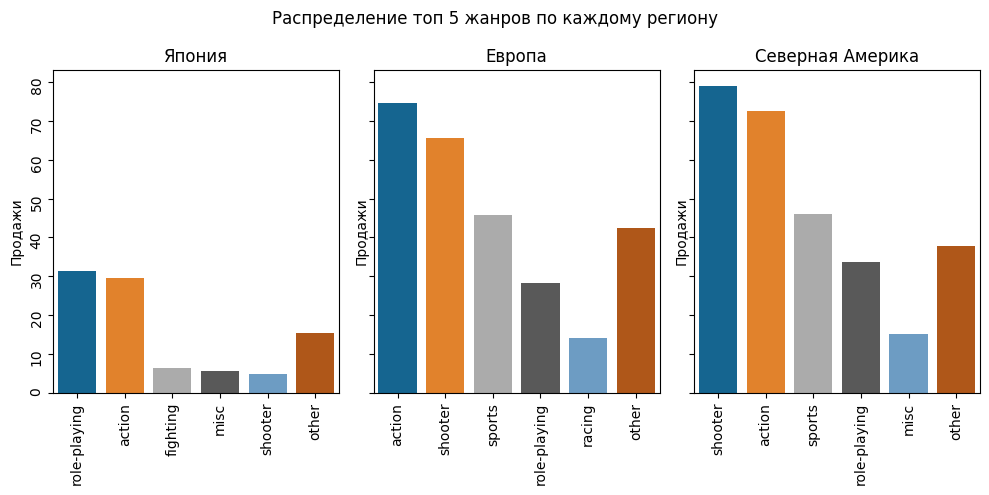

In [1004]:
fig, axs = plt.subplots(1,3,figsize = (10,5),sharey=True)
axs = axs.flatten()
fig.suptitle('Распределение топ 5 жанров по каждому региону')

info_region_obj.genre_barplot(Region.Japan, ax = axs[0])
axs[0].set_title("Япония")

info_region_obj.genre_barplot(Region.Europe, ax = axs[1])
axs[1].set_title("Европа")

info_region_obj.genre_barplot(Region.North_America, ax = axs[2])
axs[2].set_title("Северная Америка")

plt.tight_layout()

<div style="text-align: letf; background-color: #D0ECEE;font-size:100%; font-family:Tahoma; color: #000000">
      Итого

- Рынки Северной Америки и европы в целом похожи. В топ продажах находятся Shooter и Action
- Рынок Японии отличается. Шутеры находятся на третьем месте а в топе на втором месте находится role-playing, при этом жанры не в топ пять занимают значительную долю рынка

### Рассмотрим топ 5 платформ по каждому региону

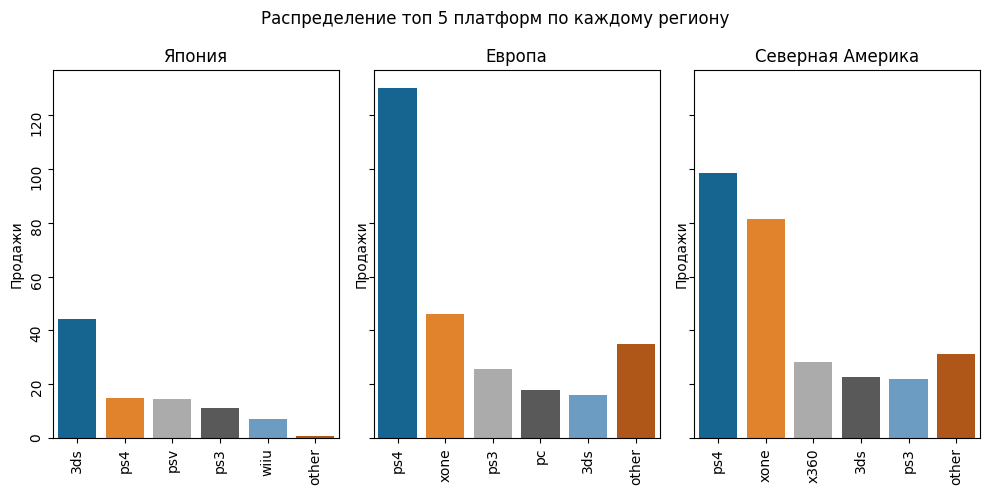

In [1005]:
fig, axs = plt.subplots(1,3,figsize = (10,5),sharey=True)
axs = axs.flatten()
fig.suptitle('Распределение топ 5 платформ по каждому региону')

info_region_obj.platform_barplot(Region.Japan, ax = axs[0])
axs[0].set_title("Япония")

info_region_obj.platform_barplot(Region.Europe, ax = axs[1])
axs[1].set_title("Европа")

info_region_obj.platform_barplot(Region.North_America, ax = axs[2])
axs[2].set_title("Северная Америка")

plt.tight_layout()

<div style="text-align: letf; background-color: #D0ECEE;font-size:100%; font-family:Tahoma; color: #000000">
      Итого

- рынки Европы и Северной америки похожи по ТОП 2 и распределению
- стоит выделить популярность pc в Европе
- в Японии на первом месте 3ds.

### Рассмотрим распределение рейтинга по рейтингу

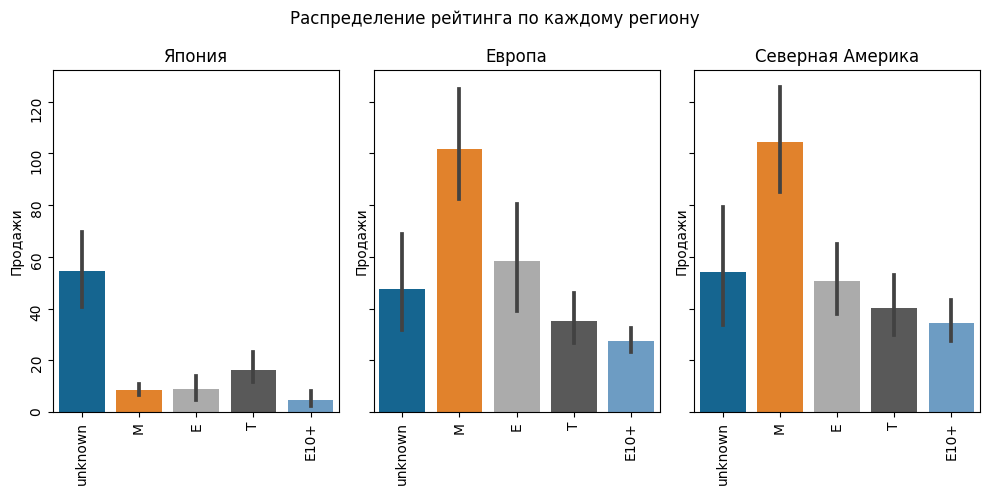

In [1006]:
fig, axs = plt.subplots(1,3,figsize = (10,5),sharey=True)
axs = axs.flatten()
fig.suptitle('Распределение рейтинга по каждому региону')

info_region_obj.rating_barplot(Region.Japan, ax = axs[0])
axs[0].set_title("Япония")

info_region_obj.rating_barplot(Region.Europe, ax = axs[1])
axs[1].set_title("Европа")

info_region_obj.rating_barplot(Region.North_America, ax = axs[2])
axs[2].set_title("Северная Америка")

plt.tight_layout()

<div style="text-align: letf; background-color: #D0ECEE;font-size:100%; font-family:Tahoma; color: #000000">
      Итого

- Возрастной рейтинг оказывает влияние на продажи
- В Европе и Америке популярны игры с рейтингом М и Е, тогда как в Японии больше всего продаж и реитингом Т
- При этом стоит отметить что в Европе игры с рейтингом Т имеют меньше всего выручки
- Рейтинг Т это рейтинг от 13 лет и в Японии он более популярен, тогде как в Европе и Северной Америке популярнее E10+, то есть игры от 10 лет

## Проверка статистических гипотез

Проверим данные на пропуски после обработки

In [1007]:
(pd.concat([data_games.isna().sum(), data_games.isna().sum() / data_games.shape[0]],axis = 1)
   .rename(columns = {0:'count_missing',1:'per_missing'})
   .sort_values('per_missing', ascending = False)
   .style.format({'per_missing': '{:.1%}'}))

,count_missing,per_missing
critic_score,971,57.5%
user_score,801,47.4%
name,0,0.0%
platform,0,0.0%
year_of_release,0,0.0%
genre,0,0.0%
na_sales,0,0.0%
eu_sales,0,0.0%
jp_sales,0,0.0%
other_sales,0,0.0%


для дальнейшей проверки надо удалить пропуски

In [1008]:
data_games_stat = data_games.dropna(subset = ['user_score', 'critic_score'])

Проверим данные на нормальность

In [1009]:
def return_normal_test(data, description):
    stat, p = st.shapiro(data)

    print(f'stat={stat:.3f}, p={p:.3f}')
    print(description)
    if p > 0.05:
        print('Нет досточных оснований, чтобы отклонить H0')
    else:
        print('Есть достаточно оснований, чтобы отклонить H0, принимаем H1.')

In [1010]:
return_normal_test(data_games_stat.query('platform == "xone"')['user_score'], 'Пользователи Xone,рейтинг')
return_normal_test(data_games_stat.query('platform == "pc"')['user_score'], 'Пользователи PC, рейтинг')
return_normal_test(data_games_stat.query('genre == "action"')['user_score'], 'Жанр Action, рейтинг')
return_normal_test(data_games_stat.query('genre == "sports"')['user_score'], 'Пользователи Sport, рейтинг')

stat=0.959, p=0.000
Пользователи Xone,рейтинг
Есть достаточно оснований, чтобы отклонить H0, принимаем H1.
stat=0.953, p=0.000
Пользователи PC, рейтинг
Есть достаточно оснований, чтобы отклонить H0, принимаем H1.
stat=0.895, p=0.000
Жанр Action, рейтинг
Есть достаточно оснований, чтобы отклонить H0, принимаем H1.
stat=0.976, p=0.131
Пользователи Sport, рейтинг
Нет досточных оснований, чтобы отклонить H0


Данные пользователей распределены с вероятностью ошибки в 13%

#### Проверка, что пользовательские рейтинги платформ Xbox One и PC одинаковые.

H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые \
H1: Средние пользовательские рейтинги платформ Xbox One и PC не одинаковые.

In [1011]:
stat, p = st.ttest_ind(data_games_stat.query('platform == "xone" and year_of_release > 2012')['user_score'], 
                       data_games_stat.query('platform == "pc" and year_of_release > 2012')['user_score'])
print(f'stat={stat:.3f}, p={p:.3f}')
if p > 0.05:
    print('Нет досточных оснований, чтобы отклонить H0')
else:
    print('Есть достаточно оснований, чтобы отклонить H0, принимаем H1.')

stat=1.526, p=0.128
Нет досточных оснований, чтобы отклонить H0


Возьмем период с 2012 года, так как одна из платформ вышла совсем недавно \
Полученное значение p-value говорит о том, что с вероятностью в почти 13% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними чеками.

#### Проверка, что средние пользовательские рейтинги жанров Action и Sports разные.

H0: Средние пользовательские рейтинги платформ Action и Sports  одинаковые \
H1: Средние пользовательские рейтинги платформ Action и Sports не одинаковые.

In [1012]:
stat, p = st.ttest_ind(data_games_stat.query('genre == "action"')['user_score'], 
                       data_games_stat.query('genre == "sports"')['user_score'])
print(f'stat={stat:.3f}, p={p:.3f}')
if p > 0.05:
    print('Нет досточных оснований, чтобы отклонить H0')
else:
    print('Есть достаточно оснований, чтобы отклонить H0, принимаем H1.')

stat=6.461, p=0.000
Есть достаточно оснований, чтобы отклонить H0, принимаем H1.


Полученное значение p-value говорит о том, вероятность получить такие значения стремится к нулю

<div style="text-align: letf; background-color: #D0ECEE;font-size:100%; font-family:Tahoma; color: #000000">

      Итого для обоих проверок были применен тест стьюдента
- Полученное значение p-value при сравнении оценок пользователей Xbox One и PC  говорит о том, что с вероятностью в почти 13% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними чеками.
- Полученное значение p-value при сравнении пользовательских рейтингов Action и Sports говорит о том, что то, что то, различие получено случайно составляет 99,99 процентов

In [1013]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:

    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.19124505225722097
Не получилось отвергнуть нулевую гипотезу


## Интерактивные графики с данными

Данные графики были использованы для поиска зависимостей по платформе и рейтингу, также туда были занесены другие значения \
Данный формат удобен тем, что можно быстро построить нужный график и увидеть тренды по различным показателям

In [1014]:
data_games = data_games.astype({'year_of_release':str})

In [1015]:
def get_interactive_plot(data:pd.DataFrame,y_column:str,x_column:str,filter_val,function:str):
    """Функция принимает измерения и функцию и возвращает интерактивный Barplot"""

    def group_data(data, filter_x):
        """Функция, которая группирует данные"""
        return data.query(f'{filter_val} == "{filter_x}"').groupby(x_column).agg(function)[y_column]
        
    df = data.groupby(x_column)[y_column].agg(function)
    fig = go.Figure()

    #добавляем общее значение
    fig.add_trace(go.Bar(x=df.index,y=df.values,visible=True))

    updatemenu = []
    buttons = []
    # button with one option for each dataframe
    for filter_x in data_games[filter_val].unique():
        buttons.append(dict(method='restyle',
                            label=filter_x,
                            visible=True,
                            args=[{'y':[group_data(data,filter_x).values],
                                   'x':[group_data(data,filter_x).index],
                                   'type':'bar'}, [0]],
                            )
                      )

    updatemenu = []
    your_menu = dict()
    updatemenu.append(your_menu)

    updatemenu[0]['buttons'] = buttons
    updatemenu[0]['direction'] = 'down'
    updatemenu[0]['showactive'] = True

    # add dropdown menus to the figure
    fig.update_layout(showlegend=False, updatemenus=updatemenu)
    fig.show()

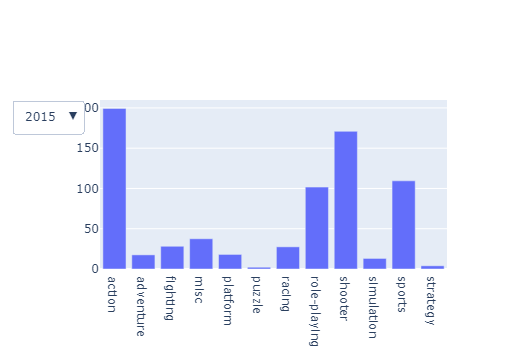

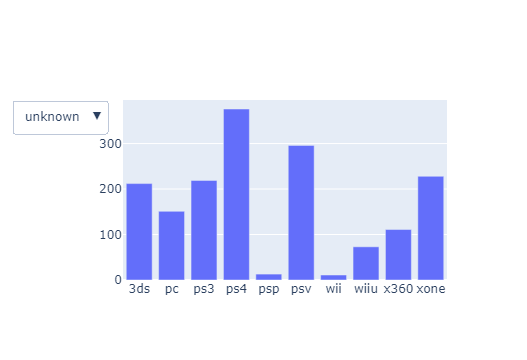

In [1016]:
get_interactive_plot(data = data_games,y_column = 'total_sales', 
                     x_column = 'genre', 
                     function = 'sum',
                     filter_val = 'year_of_release' )
get_interactive_plot(data = data_games,
                     y_column = 'total_sales', 
                     x_column = 'platform', 
                     function = 'count',
                     filter_val = 'rating' )

## Итого

🔁 Предобработка
- Явных дубликатов не наблюдалось
- Удалили дубликаты игр, одинаковых по жанру, платформе и дате выхода. Таких оказалось 2 шт
- Преобразовали user_score. tbd заменили на nan, чтобы затем обработать
- Удалили две строчки с неактуальными данными, остальные заменили на медианы или моду
- Добавили total_sales, чтобы считать продажи по всем регионам

📶 Исследовательский анализ
- Исходя из количества игр по годам видно, что основной тренд последних платформ начался в 2013 году, до этого данные удалили
- Средний период жизни платформы 8 лет
- Наиболее прибыльные в будущем платформы, те которые не устарели, и у которых в последние годы есть продажи.  Это 'ps4', 'xone', '3ds', и 'pc'
- Среди платформ, имеюших тенденцию к росту можно отметить PS4 И XOne. Также можно отметить PC платформу, которая имеет стабильные продажи с 1995 года
- Оценка зрителей коррелирует с продажами игр, оценка критиков нет. При этом зависимость есть. на популярных площадках критики чаще угадывают топ игры и редко им стявят низкие оценки
- Для платформ в первую очередь важно следить за сроком жизни. Это особенно заметно на PS, где стараются регулярно обновлять её
- Для платформ важно наличие хитов, именно они определяют, будет ли платформа иметь прибыль. Медианное значение млн продаж игр примерно у всех игр схоже
- Среди жанров наблюдается четкое разделение по популярность. Наиболее популярные жанры это Action и Sports. Менее популярные Adventure, Strategy, Puzzle

🧔 Портрет пользователя
- Жанры. 
    - Рынки Северной Америки и европы в целом похожи. В топ продажах находятся Shooter и Action
    - Рынок Японии отличается. Шутеры находятся на третьем месте а в топе на втором месте находится role-playing, при этом жанры не в топ пять занимают значительную долю рынка
- Платформы
    - рынки Европы и Северной америки похожи по ТОП 2 и распределению
    - стоит выделить популярность pc в Европе
    - в Японии на первом месте 3ds.
- Рейтинги
- Возрастной рейтинг оказывает влияние на продажи
- В Европе и Америке популярны игры с рейтингом М и Е, тогда как в Японии больше всего продаж и реитингом Т
- При этом стоит отметить что в Европе игры с рейтингом Т имеют меньше всего выручки
- Рейтинг Т это рейтинг от 13 лет и в Японии он более популярен, тогде как в Европе и Северной Америке популярнее E10+, то есть игры от 10 лет

⏺ Статистические тесты
- Полученное значение p-value при сравнении оценок пользователей Xbox One и PC  говорит о том, что с вероятностью в почти 13% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними чеками.
- Полученное значение p-value при сравнении пользовательских рейтингов Action и Sports говорит о том, что то, что то, различие получено случайно составляет 99,99 процентов